In [1]:
from seriesNet_torch import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
import random
import glob
from action_500FN import action, load_dataset
import matplotlib.pyplot as plt

In [2]:
action_1 = action('A_data.csv')
#action_2 = action('A_data.csv')
#a = [action_1.to_tensor(), action_2.to_tensor()]
#a = np.stack(a, axis=0)
#CC = torch.tensor(a)
#myAction.data.head()
#print(myAction.data[['open','high','low','close','volume']].to_numpy()[:,1:-1].dtype)
#print(myAction.data.to_numpy(dtype='float64')[:,1:-1].dtype)
all_files = glob.glob(".\\individual_stocks_5yr/" + "/*.csv")

DD = load_dataset(".\\individual_stocks_5yr\\")

DD.size()

505


torch.Size([470, 5, 1259])

In [3]:
print(DD.size()[0])
index = []
for x in range(10):
  index.append(random.randint(1,DD.size()[0]))
print(index)
print(DD[index][3] == DD[index[3]])


470
[203, 427, 130, 149, 259, 289, 312, 32, 409, 419]
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


torch.Size([5, 1259])
torch.Size([5, 1])
tensor(7554)
tensor(0)
torch.Size([1259])


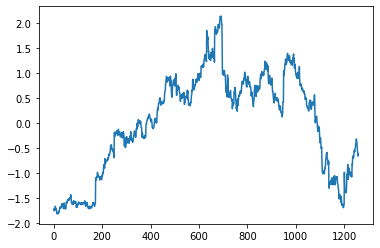

In [4]:
choice = torch.multinomial(torch.tensor(np.arange(DD.size()[0])).float(), 2)
DD[choice].size()
#print((DD.sum(axis=2)/DD.size()[2]) == DD.mean(axis=2))
DD.std(axis=2).size()
print(DD[0].size())
print(DD.mean(axis=2)[0].reshape(5,1).size())
AA = DD - DD.mean(axis=2).reshape(470,5,1)
#print(DD.std(axis=2).reshape(470,5,1))
#print((DD - DD.mean(axis=2).reshape(470,5,1)) / DD.std(axis=2).reshape(470,5,1))


AA = (DD - DD.mean(axis=2).reshape(470,5,1)) / DD.std(axis=2).reshape(470,5,1)

print(torch.isnan(AA).sum())

AA[torch.isnan(AA)] = 0

print(torch.isnan(AA).sum())
print(AA[2,1].size())
plt.plot(AA[2,1])

In [6]:
random.choice(np.arange(470))
myModel = seriesNet(5, 5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=3)
print(myModel)

seriesNet(
  (module_block): ModuleList(
    (0): gated_block(
      (pad_input): ReflectionPad1d((1, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
    )
    (1): gated_block(
      (pad_input): ReflectionPad1d((2, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), dilation=(2,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
    )
    (2): gated_block(
      (pad_input): ReflectionPad1d((4, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), dilation=(4,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bi

In [7]:
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
#print(CC.size())
# SEPARER LES CIBLES DE L'OUTPUT
data = AA[:,:,:-1].float()

target = AA[:,:,1:].float()

N = 10
# INITIALISER LE MODELE :
myModel = seriesNet(5, 5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=3)
myModel = myModel.float()

# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.0001, weight_decay=0.01)
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(3000):
    choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), N)
    output = myModel(data[choice])
    #print(output)
    optimizer.zero_grad()
    loss = criterion(output, target[choice])  
    print(" loss : ", loss)
    loss.backward()
    #print(myModel.conv_final.weight.grad)
    #print("test 2 ")
    #print(myModel.gated_block2.conv.weight.grad)
    optimizer.step()



test 3
 loss :  tensor(1.2262, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2363, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2382, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2081, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2290, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2372, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2077, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1943, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2164, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2309, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2235, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2306, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2014, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2115, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2379, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2033, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2106, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1951, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2082, grad_fn=<MseLossBackward>)
 loss :  tensor(1.2021, 

 loss :  tensor(1.0615, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1169, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0918, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0733, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0425, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1123, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1061, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1020, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1054, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1122, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0923, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1122, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1189, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0852, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1084, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1093, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0819, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1088, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0976, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1122, grad_fn

 loss :  tensor(0.9851, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0410, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0316, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0223, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0395, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0307, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0349, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0266, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0228, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0313, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0331, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9853, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0079, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0482, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0315, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0274, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9865, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0370, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0234, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0385, grad_fn

 loss :  tensor(0.9810, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9855, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9850, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9874, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9951, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9907, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9888, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9747, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9418, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0079, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9819, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9802, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9782, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0001, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9903, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9931, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9980, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9792, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9736, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9833, grad_fn

 loss :  tensor(0.9466, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9692, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9552, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9530, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9414, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9362, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9304, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9367, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9657, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9489, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9433, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9539, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9418, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9374, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9469, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9640, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9043, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9284, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9314, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9594, grad_fn

 loss :  tensor(0.9157, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9096, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9149, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9323, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9055, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9194, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9369, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9332, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9092, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9312, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9057, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8867, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9230, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9293, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9310, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9346, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9210, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8652, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9123, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9149, grad_fn

 loss :  tensor(0.8626, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8773, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9012, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8874, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8979, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9010, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9062, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9103, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9167, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8732, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8863, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9034, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9057, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8900, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8797, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8993, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9091, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8858, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9082, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8798, grad_fn

 loss :  tensor(0.8745, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8713, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8911, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8766, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8320, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8840, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8908, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8515, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8751, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8750, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8611, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8712, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8511, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8994, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8768, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8788, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8975, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8365, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8895, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8749, grad_fn

 loss :  tensor(0.8574, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8652, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8659, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8822, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8796, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8677, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8324, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8581, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8673, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8559, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8704, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8701, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8535, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8666, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8395, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8257, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8701, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8548, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8466, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8721, grad_fn

 loss :  tensor(0.8217, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8536, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8493, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8422, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8436, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8796, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8539, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8651, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8479, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8530, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8703, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8489, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8436, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8651, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8563, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8497, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8466, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8588, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8707, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8415, grad_fn

 loss :  tensor(0.7975, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8440, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8216, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8479, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8410, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8432, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8326, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8446, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8428, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8430, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8369, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8240, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8439, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7989, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8431, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8367, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8163, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8089, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8354, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8373, grad_fn

 loss :  tensor(0.8364, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8090, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8443, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8240, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8229, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8135, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8307, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8298, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8283, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8120, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8292, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7967, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8378, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8211, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8039, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8259, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8426, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7837, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8261, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8033, grad_fn

 loss :  tensor(0.8447, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7796, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8310, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8000, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8178, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8348, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8157, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7946, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8317, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8251, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8055, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8270, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8260, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7871, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8059, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8083, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8141, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8083, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8404, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8397, grad_fn

 loss :  tensor(0.8217, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7643, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7915, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8113, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7800, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7950, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8138, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7915, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8180, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8066, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7943, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8278, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7803, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8114, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8137, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8196, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7965, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8237, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8350, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8241, grad_fn

 loss :  tensor(0.8011, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8203, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7738, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7763, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7816, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7886, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8028, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8036, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7874, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8068, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8003, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7583, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8020, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7905, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7910, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8057, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8150, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8070, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7920, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8151, grad_fn

 loss :  tensor(0.7808, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7703, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7255, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7868, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7994, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7838, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7999, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7993, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7794, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7773, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8028, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7944, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7974, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7831, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7718, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7968, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7692, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8117, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8160, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8138, grad_fn

 loss :  tensor(0.7693, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7818, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7874, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7726, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7657, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7870, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8029, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7816, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7970, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7971, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7989, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8205, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8040, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7976, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7711, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7723, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8033, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7720, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7718, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8027, grad_fn

 loss :  tensor(0.7897, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7746, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8018, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7928, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7737, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7717, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7444, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7844, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7797, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7908, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7799, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7930, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7516, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7877, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7662, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7638, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7582, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8075, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7592, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7884, grad_fn

 loss :  tensor(0.7884, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7580, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7655, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7625, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7874, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7754, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7440, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7917, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7666, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7617, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7750, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7748, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7499, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7726, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7784, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7889, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7485, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7914, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7566, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7925, grad_fn

torch.Size([1, 5, 1258])


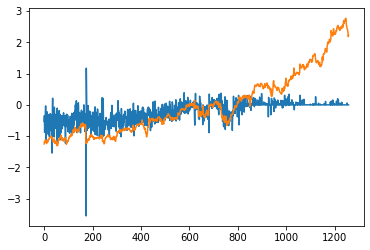

In [8]:
i=random.choice(np.arange(470))

output = myModel(data[i:i+1])
print(output.size())
plt.plot(output[0,1].detach().numpy())
plt.plot(target[i,1])